## Kaggle "News Category" Dataset

### (For Colab) Mount Drive, check environment, and install packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# Check GPU
!nvidia-smi

Thu May  7 01:12:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6

  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-m38aw_3k
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-m38aw_3k
  Created wheel for d2l: filename=d2l-0.11.4-cp36-none-any.whl size=31941 sha256=0be1a72d7f5afc95f5a0b14718cdc824cf2257926d07207e15f2d1fb2d76fc64
  Stored in directory: /tmp/pip-ephem-wheel-cache-cgtm02qs/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l
     |████████████████████████████████| 711.0MB 11kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
# Verify MXNet detects GPU
import d2l
d2l.try_all_gpus()

# Should say [gpu(0)], NOT [cpu(0)]

[gpu(0)]

### Load data and encode labels

In [3]:
import pandas as pd
import numpy

# For local use
# newscat_raw = pd.read_json("./news-category-dataset/News_Category_Dataset_v2.json", lines = True)

# For Colab
newscat_raw = pd.read_json("/content/drive/My Drive/news-category-dataset/News_Category_Dataset_v2.json", lines = True)

newscat_raw.head()


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [4]:
len(newscat_raw)

200853

In [5]:
# We have over 200k examples.
pd.value_counts(newscat_raw['category'])


POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

There are 41 categories here, with as few as 1,004 examples (EDUCATION) and as many as 32,739 (POLITICS).

One oddity is that we have "WORLDPOST" and "THE WORLDPOST". It seems like this should be one combined category.

In [6]:
newscat_raw['category'] = newscat_raw['category'].str.replace("THE WORLDPOST", "WORLDPOST")
pd.value_counts(newscat_raw['category'])

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
WORLDPOST          6243
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, dtype: int64

Now that we have combined "THE WORLDPOST" and "WORLDPOST" into a single category, we have 40 total categories. It's still not clear how, for example, WORLDPOST is different from WORLD NEWS.

In [7]:
# Check for missing values
newscat_raw.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

In [8]:
# This dataset is nice and clean! No null values to worry about!
# We have a headline, an author, and a short description to work with. Let's bring them all into one descriptor column

newscat_raw['full_description'] = newscat_raw[['authors','headline','short_description']].agg(' '.join, axis = 1)

# Maybe we shouldn't use the author (after discussion we will leave it in)
# newscat_raw['full_description'] = newscat_raw[['headline','short_description']].agg(' '.join, axis = 1)

newscat_raw.head()

,category,headline,authors,link,short_description,date,full_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,Melissa Jeltsen There Were 2 Mass Shootings In...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Andy McDonald Will Smith Joins Diplo And Nicky...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Ron Dicker Hugh Grant Marries For The First Ti...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Ron Dicker Jim Carrey Blasts 'Castrato' Adam S...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Ron Dicker Julianna Margulies Uses Donald Trum...


In [9]:
# Let's remove the stopwords from our data
# We'll use the stopwords list from the nltk corpus
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Convert to string
newscat_raw['full_description'] = newscat_raw['full_description'].astype("string")

# Remove special characters
newscat_raw['full_description'] = newscat_raw['full_description'].str.replace(r'[^\w\s]+','') # Had to read up on Regex, but this finally got rid of punctuation! -JC

# Convert to lower, tokenize, and remove stop words
newscat_raw['full_description'] = newscat_raw['full_description'].str.lower().str.split()
newscat_raw['full_description'] = newscat_raw['full_description'].apply(lambda x: [item for item in x if item not in stop])
newscat_raw.head(10)

,category,headline,authors,link,short_description,date,full_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,"[melissa, jeltsen, 2, mass, shootings, texas, ..."
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,"[andy, mcdonald, smith, joins, diplo, nicky, j..."
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,"[ron, dicker, hugh, grant, marries, first, tim..."
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,"[ron, dicker, jim, carrey, blasts, castrato, a..."
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,"[ron, dicker, julianna, margulies, uses, donal..."
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26,"[ron, dicker, morgan, freeman, devastated, sex..."
6,ENTERTAINMENT,Donald Trump Is Lovin' New McDonald's Jingle I...,Ron Dicker,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.",2018-05-26,"[ron, dicker, donald, trump, lovin, new, mcdon..."
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26,"[todd, van, luling, watch, amazon, prime, that..."
8,ENTERTAINMENT,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",2018-05-26,"[andy, mcdonald, mike, myers, reveals, hed, li..."
9,ENTERTAINMENT,What To Watch On Hulu That’s New This Week,Todd Van Luling,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,2018-05-26,"[todd, van, luling, watch, hulu, thats, new, w..."


(array([1.8480e+03, 1.7310e+04, 3.3858e+04, 5.2089e+04, 3.6183e+04,
        2.4527e+04, 1.5891e+04, 1.1609e+04, 5.3040e+03, 1.4040e+03,
        4.7700e+02, 1.0200e+02, 3.4000e+01, 2.7000e+01, 7.0000e+00,
        1.3000e+01, 2.4000e+01, 3.4000e+01, 3.2000e+01, 1.9000e+01,
        2.9000e+01, 1.0000e+01, 7.0000e+00, 6.0000e+00, 2.0000e+00,
        0.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1. ,   5.8,  10.6,  15.4,  20.2,  25. ,  29.8,  34.6,  39.4,
         44.2,  49. ,  53.8,  58.6,  63.4,  68.2,  73. ,  77.8,  82.6,
         87.4,  92.2,  97. , 101.8, 106.6, 111.4, 116.2, 121. , 125.8,
        130.6, 135.4, 140.2, 145. ]),
 <a list of 30 Patch objects>)

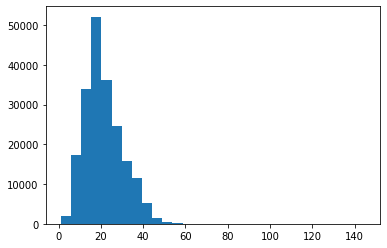

In [11]:
# Look at the token length of our descriptions

from matplotlib import pyplot as plt
plt.hist(newscat_raw['full_description'].apply(len), bins=30)

We see here that if we fix our examples at 50 tokens, it will capture the vast majority of our examples in full.

In [12]:
# Now convert our text categories to panda categories for conversion to numeric labels
labels_raw = newscat_raw["category"].astype('category')
labels_raw["category"] = newscat_raw["category"].astype('category')
labels_raw.head()

0            CRIME
1    ENTERTAINMENT
2    ENTERTAINMENT
3    ENTERTAINMENT
4    ENTERTAINMENT
Name: category, dtype: object

In [13]:
labels_raw['catnum'] = labels_raw["category"].cat.codes
labels_raw['catnum']

0          6
1         10
2         10
3         10
4         10
          ..
200848    32
200849    28
200850    28
200851    28
200852    28
Length: 200853, dtype: int8

Create dictionary for going back and forth between codes and category names

In [14]:
category_dict = dict(enumerate(labels_raw["category"].cat.categories))
category_dict

{0: 'ARTS',
 1: 'ARTS & CULTURE',
 2: 'BLACK VOICES',
 3: 'BUSINESS',
 4: 'COLLEGE',
 5: 'COMEDY',
 6: 'CRIME',
 7: 'CULTURE & ARTS',
 8: 'DIVORCE',
 9: 'EDUCATION',
 10: 'ENTERTAINMENT',
 11: 'ENVIRONMENT',
 12: 'FIFTY',
 13: 'FOOD & DRINK',
 14: 'GOOD NEWS',
 15: 'GREEN',
 16: 'HEALTHY LIVING',
 17: 'HOME & LIVING',
 18: 'IMPACT',
 19: 'LATINO VOICES',
 20: 'MEDIA',
 21: 'MONEY',
 22: 'PARENTING',
 23: 'PARENTS',
 24: 'POLITICS',
 25: 'QUEER VOICES',
 26: 'RELIGION',
 27: 'SCIENCE',
 28: 'SPORTS',
 29: 'STYLE',
 30: 'STYLE & BEAUTY',
 31: 'TASTE',
 32: 'TECH',
 33: 'TRAVEL',
 34: 'WEDDINGS',
 35: 'WEIRD NEWS',
 36: 'WELLNESS',
 37: 'WOMEN',
 38: 'WORLD NEWS',
 39: 'WORLDPOST'}

### Partition into train, validate, and test

In [0]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn, rnn
from mxnet.contrib import text
import numpy
import random
npx.set_np()

In [16]:
# Partition into training, validation, and test
train_pct = .8
validation_pct = .1
# Test set will be remainder of examples

num_examples = len(labels_raw['catnum'])
rownums = list(range(num_examples))

random.seed(1729) # Set seed so test data doesn't leak across multiple sessions
random.shuffle(rownums)

train_examples = int(num_examples * train_pct)
validation_examples = int(num_examples * validation_pct)

trainsetnums = rownums[:train_examples]
validsetnums = rownums[train_examples: train_examples + validation_examples]
testsetnums = rownums[train_examples + validation_examples: ]

print("Train/Validate/Test count: ", len(trainsetnums), len(validsetnums), len(testsetnums))

Train/Validate/Test count:  160682 20085 20086


In [0]:
Examples_train = list(newscat_raw['full_description'][trainsetnums])
Examples_validation = list(newscat_raw['full_description'][validsetnums])
Examples_test = list(newscat_raw['full_description'][testsetnums])

train_labels = list(labels_raw['catnum'][trainsetnums])
validation_labels = list(labels_raw['catnum'][validsetnums])
test_labels = list(labels_raw['catnum'][testsetnums])

In [18]:
y_train = np.array(labels_raw['catnum'][trainsetnums], dtype = np.float32).reshape(-1, 1)
y_validation = np.array(labels_raw['catnum'][validsetnums], dtype = np.float32).reshape(-1, 1)
y_test = np.array(labels_raw['catnum'][testsetnums], dtype = np.float32).reshape(-1, 1)

print(y_train.shape, len(Examples_train))
print(y_validation.shape, len(Examples_validation))
print(y_test.shape, len(Examples_test))

(160682, 1) 160682
(20085, 1) 20085
(20086, 1) 20086


In [0]:

### We changed our text preprocessing so our examples are already split into words above.
 

#  def tokenize(lines, token='word'):
#     if token == 'word':
#         return [line.split(' ') for line in lines]
#     elif token == 'char':
#         return [list(line) for line in lines]
#     else:
#         print('ERROR: unknown token type '+token)
        
# train_tokens = tokenize(Examples_train, token = 'word')
# validation_tokens = tokenize(Examples_validation, token = 'word')
# test_tokens = tokenize(Examples_test, token = 'word')


train_tokens = Examples_train
validation_tokens = Examples_validation
test_tokens = Examples_test

Let's look at some random examples from the training data to see if our headlines and categories make sense.

In [25]:
example_num = random.randint(0,len(trainsetnums))
print(train_tokens[example_num])
print(category_dict.get(int(y_train[example_num])))

['willa', 'frej', 'harrowing', 'videos', 'show', 'moments', 'earthquake', 'struck', 'mexico', 'primary', 'school', 'major', 'university', 'among', 'buildings', 'destroyed']
WORLD NEWS


### Word Embeddings

We'll use the `Vocab` function defined in D2L 8.2.

In [0]:
# TODO(JC): I'm trying to avoid calling the d2l package directly, but I'm having a hard time  
#           adapting the Vocab function from the version defined in d2l 8.2.
#           UPDATE: Given time constraints, let's just keep the d2l function here. 

import d2l
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>']) 

In [27]:
print(vocab.token_freqs[:20]) # Check the most frequent words. Stop words and special characters have been removed.


[('contributor', 30484), ('new', 15867), ('one', 12643), ('us', 12048), ('trump', 10797), ('time', 9736), ('people', 9640), ('like', 9297), ('author', 9109), ('photos', 9001), ('day', 8420), ('life', 7895), ('get', 7613), ('make', 7282), ('world', 6741), ('first', 6523), ('writer', 6380), ('dont', 6337), ('best', 6068), ('know', 6035)]


In [28]:
# Load pre-trained GloVe word embedding. This is available as a resource in mxnet. 
# We'll follow d2l's lead and use the 100d version
glove_embedding = text.embedding.create(
    'glove', pretrained_file_name='glove.6B.100d.txt')

# Check the dimentions of our embeddings (should be vocab size x dimensionality of embedding we chose)
embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(37208, 100)

### Data iterator

In [29]:
num_steps = 50  # Sequence length. We saw above that 50 should be plenty.
train_features = np.array([d2l.truncate_pad(  ###JC: Another invocation of d2l library
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

validation_features = np.array([d2l.truncate_pad(  ###JC: Another invocation of d2l library
    vocab[line], num_steps, vocab['<pad>']) for line in validation_tokens])
print(validation_features.shape)

test_features = np.array([d2l.truncate_pad(  ###JC: Another invocation of d2l library
    vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
print(test_features.shape)


(160682, 50)
(20085, 50)
(20086, 50)


In [0]:
X_train = np.array(train_features, dtype = np.float32)
X_validation = np.array(validation_features, dtype = np.float32)
X_test = np.array(test_features, dtype = np.float32)

In [31]:
batch_size = 128
train_iter = d2l.load_array((train_features, train_labels), batch_size)   ###JC: Another invocation of d2l library
validation_iter = d2l.load_array((validation_features, validation_labels), batch_size, is_train = False)   
test_iter = d2l.load_array((test_features, test_labels), batch_size, is_train = False)   


for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break
'# batches:', len(train_iter)

X (128, 50) y (128,)


('# batches:', 1256)

### Training Loop

In [0]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, lr, batch_size, ctx=d2l.try_gpu()):
  loss = gluon.loss.SoftmaxCrossEntropyLoss()
  train_ls, train_acc, test_acc = [], [], []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  test_iter = d2l.load_array((test_features, test_labels), batch_size, is_train = False)
  trainer = gluon.Trainer(net.collect_params(),
                              'adam', {'learning_rate': lr})
  
  for epoch in range(num_epochs):
    train_acc_minibatch = []
    train_ls_minibatch = []
    test_acc_minibatch = []
    for i, (X, y) in enumerate(train_iter):
      X, y = X.as_in_ctx(ctx), y.as_in_ctx(ctx)
      with autograd.record():
        y_hat = net(X)
        l = loss(y_hat, y)
      l.backward()
      # print("Minibatch Completed")
      if(len(y) == batch_size): # Only calculate on full minibatches
        train_accuracy = (net(X).argmax(axis = 1).reshape(-1, 1) == 
                          y).sum()/len(y)
        train_loss = loss(net(X), y).mean()
        train_acc_minibatch.append(train_accuracy)
        train_ls_minibatch.append(train_loss)
      # print(train_accuracy)
      trainer.step(batch_size)

    # Validation set is too large to evaluate all at once.
    # Loop to evaluate test accuracy in minibatches.
    for i, (Xtest, ytest) in enumerate(test_iter):
      Xtest, ytest = Xtest.as_in_ctx(ctx), ytest.as_in_ctx(ctx)
      if(len(ytest) == batch_size): # Only calculate on full minibatches
        test_accuracy = (net(Xtest).argmax(axis = 1).reshape(-1, 1) == 
                          ytest).sum()/len(ytest)
        test_acc_minibatch.append(test_accuracy)


    train_acc.append(np.array(train_acc_minibatch).mean())
    test_acc.append(np.array(test_acc_minibatch).mean())
    train_ls.append(np.array(train_ls_minibatch).mean())
    print("Epoch = %d: Train acc: %f, Test acc: = %f" % (epoch, train_acc[-1], test_acc[-1]))
  return train_ls, train_acc, test_acc

### One-layer LSTM (one-directional)

In [0]:
class RNNModel(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                bidirectional=False, input_size=embed_size,
                                dropout = 0.2)
        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
    
        # encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        # Use final timestep for prediction
        encoding = outputs[-1]
        outs = self.decoder(encoding)
        return outs

Epoch = 0: Train acc: 0.451121, Test acc: = 0.606070
Epoch = 1: Train acc: 0.637849, Test acc: = 0.648137
Epoch = 2: Train acc: 0.665886, Test acc: = 0.643680
Epoch = 3: Train acc: 0.676102, Test acc: = 0.667768
Epoch = 4: Train acc: 0.686815, Test acc: = 0.670923
Training time 95.22796 sec
Training loss: 1.100057
Train accuracy: 0.686815
Validation accuracy: 0.670923


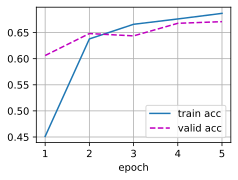

In [37]:
embed_size, num_hiddens, num_layers, ctx = 100, 256, 1, d2l.try_all_gpus()
net = RNNModel(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

lr, num_epochs, batch_size = 0.02, 5, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])


### Two-layer LSTM (one-directional)

Epoch = 0: Train acc: 0.432115, Test acc: = 0.643379
Epoch = 1: Train acc: 0.690326, Test acc: = 0.705579
Epoch = 2: Train acc: 0.729818, Test acc: = 0.721504
Epoch = 3: Train acc: 0.748276, Test acc: = 0.731270
Epoch = 4: Train acc: 0.760433, Test acc: = 0.732522
Epoch = 5: Train acc: 0.769211, Test acc: = 0.734075
Epoch = 6: Train acc: 0.773780, Test acc: = 0.740535
Epoch = 7: Train acc: 0.779532, Test acc: = 0.742238
Epoch = 8: Train acc: 0.782520, Test acc: = 0.743590
Epoch = 9: Train acc: 0.786243, Test acc: = 0.745393
Training time 238.58175 sec
Training loss: 0.716942
Train accuracy: 0.786243
Validation accuracy: 0.745393


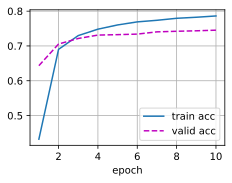

In [40]:
embed_size, num_hiddens, num_layers, ctx = 100, 256, 2, d2l.try_all_gpus()
net = RNNModel(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

lr, num_epochs, batch_size = 0.01, 10, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])


### GRU 1-layer

In [0]:
class GRUBlock(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(GRUBlock, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.GRU(num_hiddens, num_layers=num_layers,
                                bidirectional=False, input_size=embed_size,
                                dropout = 0.2)
        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
    
        # encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        # Use final timestep for prediction
        encoding = outputs[-1]
        outs = self.decoder(encoding)
        return outs

Epoch = 0: Train acc: 0.639641, Test acc: = 0.690204
Epoch = 1: Train acc: 0.702160, Test acc: = 0.697716
Epoch = 2: Train acc: 0.709499, Test acc: = 0.695663
Epoch = 3: Train acc: 0.710483, Test acc: = 0.698468
Epoch = 4: Train acc: 0.704663, Test acc: = 0.666216
Training time 94.12884 sec
Training loss: 1.035032
Train accuracy: 0.704663
Validation accuracy: 0.666216


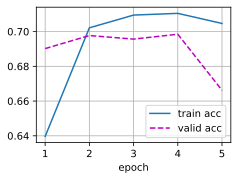

In [46]:
embed_size, num_hiddens, num_layers, ctx = 100, 256, 1, d2l.try_all_gpus()
net = GRUBlock(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

lr, num_epochs, batch_size = 0.01, 5, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])


### GRU 2-layer

Epoch = 0: Train acc: 0.548332, Test acc: = 0.450120
Epoch = 1: Train acc: 0.562730, Test acc: = 0.605318
Epoch = 2: Train acc: 0.627366, Test acc: = 0.644281
Epoch = 3: Train acc: 0.647603, Test acc: = 0.653496
Epoch = 4: Train acc: 0.660184, Test acc: = 0.642879
Training time 107.25292 sec
Training loss: 1.208765
Train accuracy: 0.660184
Validation accuracy: 0.642879


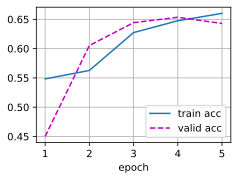

In [47]:
embed_size, num_hiddens, num_layers, ctx = 100, 256, 2, d2l.try_all_gpus()
net = GRUBlock(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

lr, num_epochs, batch_size = 0.01, 5, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])


### Bi-Directional GRU: Two Layers



In [0]:
class BiGRU(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiGRU, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.GRU(num_hiddens, num_layers=num_layers,
                                bidirectional=True, input_size=embed_size,
                                dropout = 0.2)
        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
        # Concatenate the hidden states of the initial timestep and final
        # timestep to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
        encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        outs = self.decoder(encoding)
        return outs

Epoch = 0: Train acc: 0.618159, Test acc: = 0.670172
Epoch = 1: Train acc: 0.683815, Test acc: = 0.677835
Epoch = 2: Train acc: 0.696638, Test acc: = 0.686999
Epoch = 3: Train acc: 0.689772, Test acc: = 0.671524
Epoch = 4: Train acc: 0.687954, Test acc: = 0.682792
Training time 183.96759 sec
Training loss: 1.087089
Train accuracy: 0.687954
Validation accuracy: 0.682792


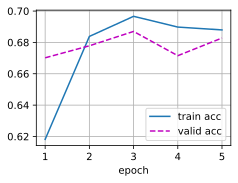

In [49]:
embed_size, num_hiddens, num_layers, ctx = 100, 200, 2, d2l.try_all_gpus()
net = BiGRU(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

lr, num_epochs, batch_size = 0.01, 5, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])

### Bi-GRU One Layer

Epoch = 0: Train acc: 0.660956, Test acc: = 0.694411
Epoch = 1: Train acc: 0.702851, Test acc: = 0.689353
Epoch = 2: Train acc: 0.714293, Test acc: = 0.698818
Epoch = 3: Train acc: 0.726824, Test acc: = 0.706380
Epoch = 4: Train acc: 0.740669, Test acc: = 0.711338
Training time 112.38288 sec
Training loss: 0.899931
Train accuracy: 0.740669
Validation accuracy: 0.711338


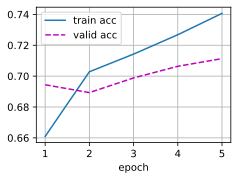

In [52]:
embed_size, num_hiddens, num_layers, ctx = 100, 200, 1, d2l.try_all_gpus()
net = BiGRU(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

lr, num_epochs, batch_size = 0.01, 5, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])

### Softmax Regression (Embedding to Dense)

In [0]:
class LinearBlock(nn.Block):
    def __init__(self, vocab_size, embed_size, **kwargs):
        super(LinearBlock, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)

        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs)
        outs = self.decoder(embeddings)
        return outs

Epoch = 0: Train acc: 0.543233, Test acc: = 0.566406
Epoch = 1: Train acc: 0.611529, Test acc: = 0.560697
Epoch = 2: Train acc: 0.630509, Test acc: = 0.563351
Epoch = 3: Train acc: 0.640102, Test acc: = 0.566256
Epoch = 4: Train acc: 0.650218, Test acc: = 0.564153
Training time 60.17809 sec
Training loss: 2.226562
Train accuracy: 0.650218
Validation accuracy: 0.564153


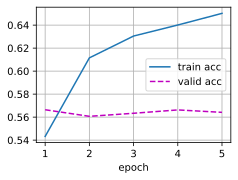

In [62]:
embed_size, ctx = 100, d2l.try_all_gpus()
net = LinearBlock(len(vocab), embed_size)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

lr, num_epochs, batch_size = 0.01, 5, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])

### MLP

In [0]:
class MLP(nn.Block):
    def __init__(self, vocab_size, embed_size, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dense_1 = nn.Dense(512, activation='relu')
        self.dense_2 = nn.Dense(512, activation='relu')
        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs)
        hidden_1 = self.dense_1(embeddings)
        hidden_2 = self.dense_2(hidden_1)
        outs = self.decoder(hidden_2)
        return outs

Epoch = 0: Train acc: 0.504015, Test acc: = 0.543770
Epoch = 1: Train acc: 0.572821, Test acc: = 0.558794
Epoch = 2: Train acc: 0.596116, Test acc: = 0.573017
Epoch = 3: Train acc: 0.615469, Test acc: = 0.573067
Epoch = 4: Train acc: 0.627720, Test acc: = 0.580879
Epoch = 5: Train acc: 0.636884, Test acc: = 0.587490
Epoch = 6: Train acc: 0.644416, Test acc: = 0.577724
Epoch = 7: Train acc: 0.652353, Test acc: = 0.576322
Epoch = 8: Train acc: 0.657987, Test acc: = 0.574068
Epoch = 9: Train acc: 0.659157, Test acc: = 0.581981
Training time 150.80777 sec
Training loss: 1.267653
Train accuracy: 0.659157
Validation accuracy: 0.581981


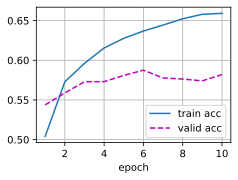

In [75]:
embed_size, ctx = 100, d2l.try_all_gpus()
net = MLP(len(vocab), embed_size)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

lr, num_epochs, batch_size = 0.01, 10, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])

### ConvNet

In [0]:
class ConvBlock(nn.Block):
    def __init__(self, vocab_size, embed_size, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.conv_1 = nn.Conv1D(channels = 50, kernel_size=3, padding = 1)
        self.pool_1 = nn.MaxPool1D(pool_size = 2, strides=1)
        self.dense_1 = nn.Dense(512, activation='relu')
        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs)
        hidden_1 = self.conv_1(embeddings)
        hidden_2 = self.pool_1(hidden_1)
        hidden_3 = self.dense_1(hidden_2)
        outs = self.decoder(hidden_3)
        return outs

Epoch = 0: Train acc: 0.494279, Test acc: = 0.520533
Epoch = 1: Train acc: 0.523898, Test acc: = 0.518029
Epoch = 2: Train acc: 0.542617, Test acc: = 0.529046
Epoch = 3: Train acc: 0.554021, Test acc: = 0.543920
Epoch = 4: Train acc: 0.556101, Test acc: = 0.543369
Epoch = 5: Train acc: 0.551693, Test acc: = 0.529097
Epoch = 6: Train acc: 0.555080, Test acc: = 0.542969
Epoch = 7: Train acc: 0.558833, Test acc: = 0.532452
Epoch = 8: Train acc: 0.560583, Test acc: = 0.537009
Epoch = 9: Train acc: 0.560321, Test acc: = 0.534355
Training time 158.22717 sec
Training loss: 1.662686
Train accuracy: 0.560321
Validation accuracy: 0.534355


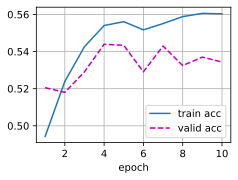

In [90]:
embed_size, ctx = 100, d2l.try_all_gpus()
net = ConvBlock(len(vocab), embed_size)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

lr, num_epochs, batch_size = 0.01, 10, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])